In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

This notebook is a blend of what I have learned from other Kaggle Notebooks and external links.

Appropriate external links are placed throughout the notebook and the following notebooks I found helpful are in the list below. 

Chinmay Rane -> https://www.kaggle.com/fuzzywizard/beginners-guide-to-cnn-accuracy-99-7

DATAI -> https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial

Chris Deotte -> https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

# Loading Data

In [2]:
#loading data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
df = train.copy()
df_test = test.copy()

In [3]:
#Just having a look at the data
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


we can see there is one column that has the label and the rest are the image pixels!

In [4]:
#check for any missing values in train data
df.isnull().any().sum()

0

In [5]:
#check for any missing values in test data
df_test.isnull().any().sum()

0

# Data PreProcessing

In [6]:
## Setting the seeds for Reproducibility.
seed = 2718 #eulers constant
np.random.seed(seed)

### Splitting Train and Test Data

In [7]:
# X is the pixels and Y is the image labels
X = train.iloc[:,1:]
Y = train.iloc[:,0]

#splitting dataframe using train_test_split
x_train , x_test , y_train , y_test = train_test_split(X, Y , test_size=0.1, random_state=seed)

### Reshaping Images

- we have a 1D vecotr with 784 pixels and we have to reshape it to (28x28x1) before passing it to the CNN. 

- This is because Keras wants an Extra Dimension in the end, for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses 1.

In [8]:
#first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself

#reshape(examples, height, width, channels)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
df_test=df_test.values.reshape(-1,28,28,1)

### Data Augmentation

Data augmentation is super important.  In terms of Images it means we can increase the number of images our model sees. 

This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc.

Keep in mind doing all these things will not always help the model. For example in our situation a vertical_flip would not be wise as 6's would become 9's and vice-versa.

In [9]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

### Normalization

Pixel values are often stored as integers in the range 0 to 255, which is the range that int-8 can offer.


Normalization:

1. Sets the value of inputs between 0-1
2. Helps Gradient Descent Converge much faster
3. Brings features to equal level and weightage
4. Helps remove distortians in an image caused by light and shadows 

In [10]:
#convert values to float as result will be a float. If not done vals are set to zero

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

In [11]:
#fitting the ImageDataGenerator we defined above
datagen.fit(x_train)

### One hot encoding labels

The labels are given as integers between 0-9. We need to one hot encode them.

For example 4 looks like this: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

This is done so that we have labels for all the classes, and we can easily carry out the Error/Cost during BackPropogation.



In [12]:
#notice num_classes is set to 10 as we have 10 different labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# Building CNN Model

For image classification CNN's are the best

NOTE: the hardest part is picking right model by understanding the data rather than by tuning hyperparameters

A larger training dataset will really help CNN accuracy

Steps:

1. Use Sequential Keras API 
2. Add Convolutional Layers - Building blocks of ConvNets and what do the heavy computation
3. Add Pooling Layers - Steps along image - reduces params and decreases likelihood of overfitting
4. Add Batch Normalization Layer - Scales down outliers, and forces NN to not relying too much on a Particular Weight
5. Add Dropout Layer -  Regularization Technique that randomly drops a percentage of neurons to avoid overfitting (usually 20% - 50%)
6. Add Flatten Layer - Flattens the input as a 1D vector
7. Add Output Layer - Units equals number of classes. Sigmoid for Binary Classification, Softmax in case of Multi-Class Classification.

In [13]:
# Building ConvNet

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compiling Model (configure learning process)

Before training the model we need to make sure we specify how the model will "learn"

1. Specify the Optimizer - The optimizer help us minimize the error function. Examples - RMSprop, Adam, AdaGrad, AdaDelta
2. Specify Loss Function -  For Binary Classification use "binary_crossentropy" and for Multi-class Classification use "categorical_crossentropy"
3. Specify the metrics to evaluate model performance



Great article here to understand the ADAM optimizer -> https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [14]:
#Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

In [15]:
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Model Summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

### Learning Rate Decay

Many optimization algorithms have a constant learning rate, which will often not reach a local minima.

To implement Learning Rate Decay we can use either LearningRateScheduler or ReduceLRonPlateau.

- LearningRateScheduler -  takes the step decay function as argument and returns updated learning rates for use in optimzer at every epoch stage.

- ReduceLRonPlateau  - monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.

In [17]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [18]:
#visualizing what the learning rate decay will do to the learning rate through every epoch
decays = [(lambda x: 1e-3 * 0.9 ** x)(x) for x in range(10)]
i=1

for lr in decays:
    print("Epoch " + str(i) +" Learning Rate: " + str(lr))
    i+=1

Epoch 1 Learning Rate: 0.001
Epoch 2 Learning Rate: 0.0009000000000000001
Epoch 3 Learning Rate: 0.0008100000000000001
Epoch 4 Learning Rate: 0.0007290000000000002
Epoch 5 Learning Rate: 0.0006561000000000001
Epoch 6 Learning Rate: 0.00059049
Epoch 7 Learning Rate: 0.000531441
Epoch 8 Learning Rate: 0.0004782969000000001
Epoch 9 Learning Rate: 0.0004304672100000001
Epoch 10 Learning Rate: 0.0003874204890000001


### Early Stopping Rounds

- I would still like to define an early stopping parameter to ensure that my model stops training once I have reached a point where it is no longer necessary to continue training. This is another way to control overfitting.

- Its important to note that we need to specify a validation dataset in the model to use an early_stopping callback

In [19]:
#by default this is evaluated on 'val_loss'
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Fitting the Model

In [20]:
#defining these prior to model to increase readability and debugging
batch_size = 64
epochs = 50

In [21]:
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=1, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr,early_stopping])

Epoch 1/50
590/590 [==============================] - 98s 166ms/step - loss: 0.3712 - accuracy: 0.8915 - val_loss: 0.1623 - val_accuracy: 0.9543
Epoch 2/50
590/590 [==============================] - 98s 167ms/step - loss: 0.1393 - accuracy: 0.9582 - val_loss: 0.0518 - val_accuracy: 0.9860
Epoch 3/50
590/590 [==============================] - 98s 165ms/step - loss: 0.0989 - accuracy: 0.9693 - val_loss: 0.0485 - val_accuracy: 0.9833
Epoch 4/50
590/590 [==============================] - 97s 165ms/step - loss: 0.0795 - accuracy: 0.9763 - val_loss: 0.0354 - val_accuracy: 0.9888
Epoch 5/50
590/590 [==============================] - 97s 165ms/step - loss: 0.0746 - accuracy: 0.9777 - val_loss: 0.0409 - val_accuracy: 0.9867
Epoch 6/50
590/590 [==============================] - 97s 164ms/step - loss: 0.0636 - accuracy: 0.9807 - val_loss: 0.0284 - val_accuracy: 0.9924
Epoch 7/50
590/590 [==============================] - 98s 166ms/step - loss: 0.0573 - accuracy: 0.9824 - val_loss: 0.0275 - val_ac

### Evaluating the model

In [22]:
import matplotlib.pyplot as plt

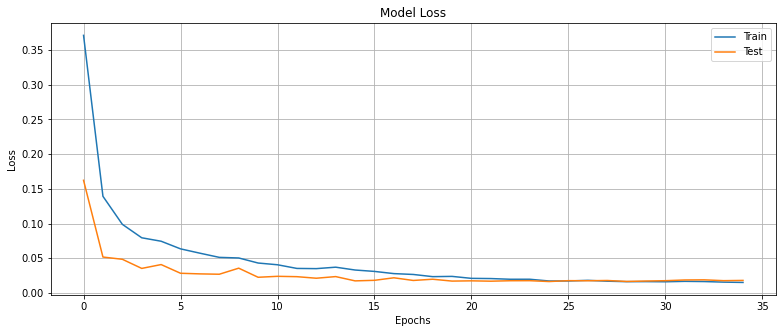

In [23]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

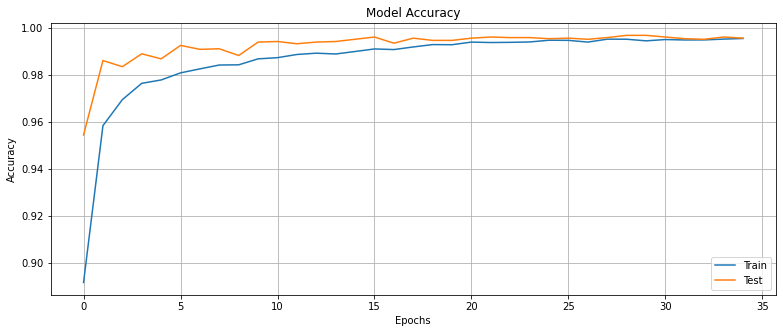

In [24]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

# Output prediction to CSV file

In [25]:
pred_digits_test = np.argmax(model.predict(df_test),axis=1)
image_id_test = []

for i in range (len(pred_digits_test)):
    image_id_test.append(i+1)
    
d = {'ImageId':image_id_test,'Label':pred_digits_test}
answer = pd.DataFrame(d)

answer.to_csv('answer.csv',index=False)